In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import yaml

In [2]:
class DengueSEIRModel:
    def __init__(self, config_file, days):
        self._read_config(config_file)
        self.t = np.linspace(0, days, days*500)
    
    def _read_config(self, config_file):
        with open(config_file, 'r') as in_file:
            config_dict = yaml.load(in_file, Loader=yaml.FullLoader)['DENGUE']
            self.params = config_dict['PARAMETERS']
            self.initial_states = config_dict["INITIAL_STATES"]
            
    def run_model(self):
        y0 = self.initial_states['Sh'], self.initial_states['Eh'], self.initial_states['Iha'],\
             self.initial_states['Ihs'], self.initial_states['Rh'], self.initial_states['Sv'], \
             self.initial_states['Ev'], self.initial_states['Iv']
        
        self.model_output = odeint(self._model_dengue, y0, self.t, args = (self,))
            
    def _model_dengue(self, y, t, p):

        # States and population
        Sh, Eh, Iha, Ihs, Rh, Sv, Ev, Iv = y
        N_h = sum([Sh, Eh, Iha, Ihs, Rh])
        N_v = sum([Sv, Ev, Iv])

        # Biting rate
        b = self.params['sigma_h'] * self.params['sigma_v'] / \
              (self.params['sigma_h'] * N_h + self.params['sigma_v'] * N_v)
        b_h = b * N_v
        b_v = b * N_h
        
        # Force of infecton
        lambda_h = b_h * self.params['beta_h'] * Iv / N_v
        lambda_v = b_v * self.params['beta_v'] * (Iha + Ihs) / N_h

        # System of equations
        dSh = -lambda_h * Sh
        dEh = lambda_h * Sh - self.params['nu_h'] * Eh
        dIha = self.params['psi'] * self.params['nu_h'] * Eh - self.params['gamma_h'] * Iha
        dIhs = (1 - self.params['psi']) * self.params['nu_h'] * Eh - self.params['gamma_h'] * Ihs
        dRh = self.params['gamma_h'] * (Iha + Ihs)
        dSv = -lambda_v * Sh
        dEv = lambda_v * Sh - self.params['nu_v'] * Ev
        dIv = self.params['nu_v'] * Ev - self.params['mu_v'] * Iv

        return dSh, dEh, dIha, dIhs, dRh, dSv, dEv, dIv
    
    def graph_model(self):#, out):
        Sh, Eh, Iha, Ihs, Rh, Sv, Ev, Iv = self.model_output.T
        fig = plt.figure(facecolor='w', figsize=[2*6.4, 2*4.8])
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
        ax.plot(self.t, Sh, 'b', alpha=0.5, lw=2, label='Susceptible Humans')
        ax.plot(self.t, Iha+Ihs, 'r', alpha=0.5, lw=2, label='Infected Humans')
        ax.plot(self.t, Iv, 'k', alpha=0.5, lw=2, label='Infected Vectors')
        #ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered')

        ax.set_xlabel('Time (days)')
        ax.set_ylabel('Cases')
        ax.yaxis.set_tick_params(length=0)
        ax.xaxis.set_tick_params(length=0)
        ax.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax.legend()
        plt.title("Dengue Incidence")
        legend.get_frame().set_alpha(0.5)
        for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)
        plt.show()

### MAIN

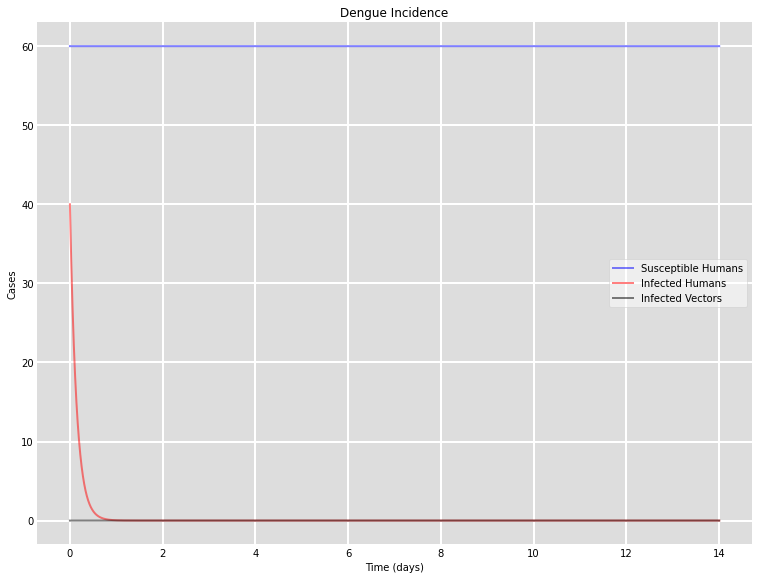

In [3]:
config_file = 'config.yaml'

den = DengueSEIRModel(config_file, days=14)
den.run_model()
den.graph_model()